# Chapter 5: 基本的な回帰とモデルのチェック
## 5.1 重回帰
### 5.1.2 データの分布の確認

*グラフの表示にseaborn-analyzerを使用した。ver0.3.5と、seaborn0.12.2以降の組み合わせでは、
pairanalyzerのdiag_kindパラメーターを使用時にエラーやuser warningが出るため以下のように修正。

custom_pair_plot.py 225行目辺り
```python
#対角にヒストグラム or KDEをプロット
        if diag_kind == "hist":
-            g.map_diag(plt.hist, **diag_kws)
+            g.map_diag(sns.histplot, **diag_kws)
        elif diag_kind == "kde":
-            diag_kws.setdefault("shade", True)
+            diag_kws.setdefault("fill", True)
            diag_kws["legend"] = False
            g.map_diag(sns.kdeplot, **diag_kws)
```

shape: (5, 3)
┌─────┬───────┬───────┐
│ A   ┆ Score ┆ Y     │
│ --- ┆ ---   ┆ ---   │
│ i64 ┆ i64   ┆ f64   │
╞═════╪═══════╪═══════╡
│ 0   ┆ 69    ┆ 0.286 │
│ 1   ┆ 145   ┆ 0.196 │
│ 0   ┆ 125   ┆ 0.261 │
│ 1   ┆ 86    ┆ 0.109 │
│ 1   ┆ 158   ┆ 0.23  │
└─────┴───────┴───────┘


/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/sean/Documents/myscript/python-ba

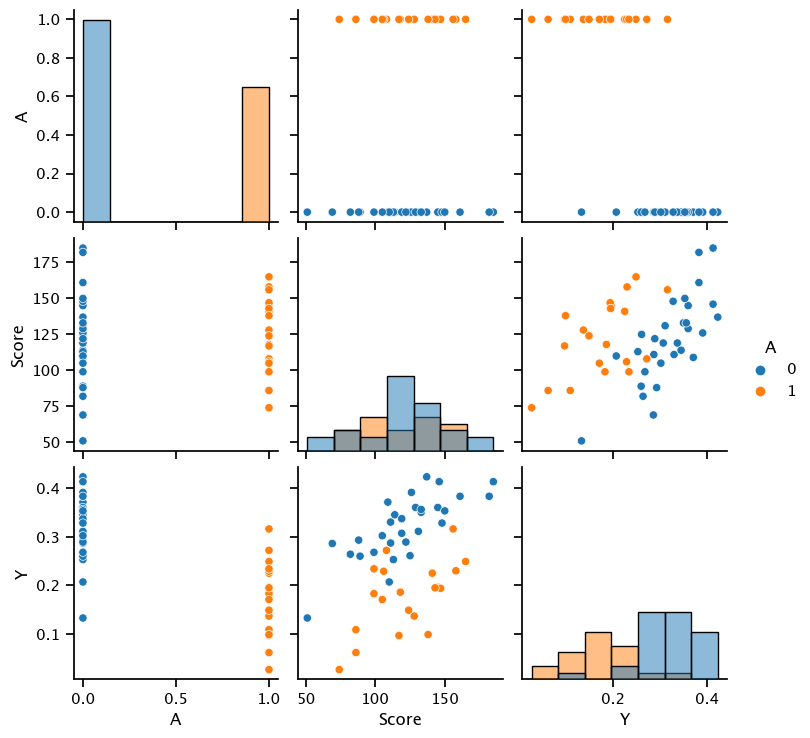

<Figure size 640x480 with 0 Axes>

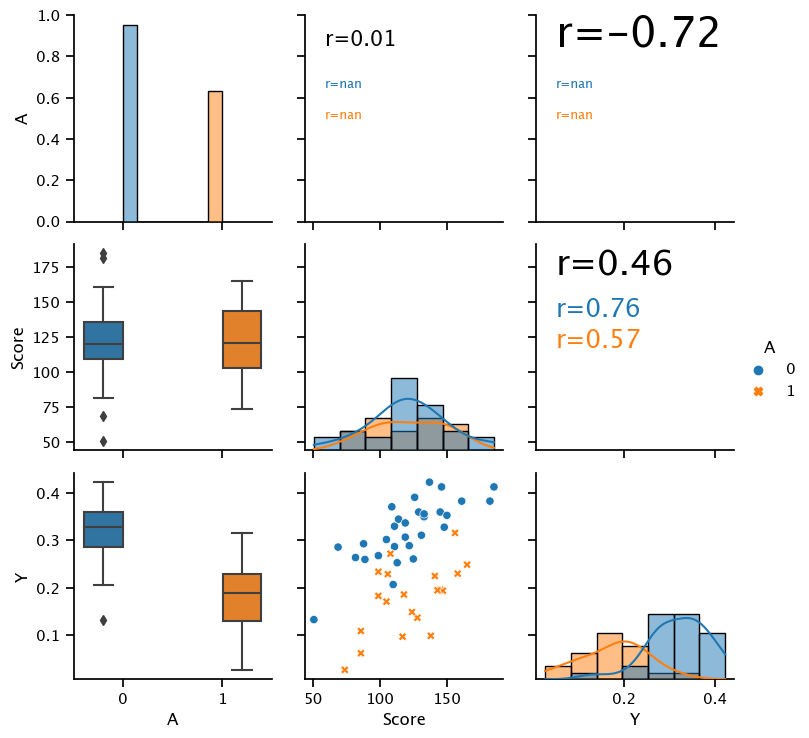

In [6]:
# scatterplot matrix(pairplot)を描画
import polars as pl
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
from seaborn_analyzer import CustomPairPlot

INPUT_FILE_PATH = Path("chap05/input/data-attendance-1.txt")

d = pl.read_csv(INPUT_FILE_PATH)
print(d.head())

# pairplotでも良いが、seaborn-analyzerを使用してグラフをテキストに合うようにできるだけカスタマイズしていく
# pairplot
sns.pairplot(d.to_pandas(), hue="A", vars=["A", "Score", "Y"], diag_kind="hist")

# seaborn-analyzerのCustomPairPlotを使用
cp = CustomPairPlot()
cp.pairanalyzer(
    d.to_pandas(),
    hue="A",
    vars=["A", "Score", "Y"],
    diag_kind="hist",
    diag_kws={"kde": True},
)

### 5.1.3 メカニズムの想像

A：アルバイトが好きかどうかを表す0/1の二値(0: 好きでない, 1:好き)
Score：学問への興味の強さを数値化したもの（200点満点）
Y：1年間の出席率 (出席回数/総出席率) 総出席率は200~500程度であるものとする

上図より、AとScoreの2つの説明変数の線形結合によってYが決まると仮定すると、$Y = b_1 + b_2A[n] + b_3Score[n]$となる。

これに確率的な変動を含むノイズ(学生ごとに異なる)$\varepsilon$を加える。このとき$\varepsilon$は平均0の正規分布に従うと考える。

### 5.1.4 モデル式の記述

モデル式 5-1
$$
\begin{align}
&Y = b_1 + b_2A[n] + b_3Score[n] + \varepsilon[n] \quad &n=1, ..., N \nonumber \\
&\epsilon[n] \sim Normal(0, \sigma) \quad &n=1, ..., N \nonumber
\end{align}
$$

モデル式 5-2 ($\varepsilon$を消去)
$$
Y[n] \sim Normal(b_1 + b_2A[n] + b_3Score[n], \sigma) \quad n=1, ..., N
$$

モデル式 5-3 (出席率のベース(平均)$\mu[n]$を考える場合)
$$
\begin{align}
&\mu[n] = b_1 + b_2A[n] + b_3Score[n] &n=1, ..., N \nonumber \\
&Y[n] \sim Normal(\mu[n], \sigma) &n=1, ..., N \nonumber
\end{align}
$$

### 5.1.5 Stanで実装

実装例

[chap05/model/model5-3.stan](chap05/model/model5-3.stan)

### 5.1.6 データのスケーリング

Pythonからstanを実行する

スケーリング(各パラメータを一般的に1程度に揃える)ためにScore(200点満点)を200で割っている

スケーリングの例
- 売上が1万円単位なら1万で割る
- データから算出した標準偏差で割る(オーソドックス)
- 標準偏差の2倍で割る (スケーリング前の-1x標準偏差~+1x標準偏差を1にしたいとき)
- データの最大値で割る

#### run-model5-3.Rのpython版

データ

[chap05/input/data-attendance-1.txt](chap05/input/data-attendance-1.txt)

In [7]:
import polars as pl
from cmdstanpy import CmdStanModel

d = pl.read_csv("chap05/input/data-attendance-1.txt")

data = {
    "N": d.shape[0],
    "A": d["A"].to_list(),
    "Score": (d["Score"] / 200).to_list(),  # スケーリング
    "Y": d["Y"].to_list(),
}

sm = CmdStanModel(
    stan_file="chap05/model/model5-3.stan", cpp_options={"STAN_THREADS": "TRUE"}
)
fit = sm.sample(data=data, seed=1234)

21:29:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:29:53 - cmdstanpy - INFO - CmdStan done processing.


### 5.1.7 推定結果の解釈

パラメーターの要約を確認

                  Mean      MCSE    StdDev         10%         50%  \
lp__        120.820000  0.042965  1.532330  118.870000  121.169000   
b1            0.122894  0.000845  0.032973    0.080746    0.122485   
b2           -0.143309  0.000361  0.015621   -0.162925   -0.143580   
b3            0.325319  0.001311  0.052515    0.259291    0.325992   
sigma         0.051940  0.000118  0.005395    0.045485    0.051518   
...                ...       ...       ...         ...         ...   
y_pred[46]    0.293362  0.000854  0.053150    0.225870    0.293151   
y_pred[47]    0.204437  0.000976  0.056433    0.132267    0.204583   
y_pred[48]    0.366567  0.000898  0.053644    0.297766    0.365895   
y_pred[49]    0.285588  0.000876  0.052662    0.218258    0.286721   
y_pred[50]    0.141675  0.000890  0.054118    0.072484    0.140542   

                   90%    N_Eff  N_Eff/s     R_hat  
lp__        122.364000  1271.95  2753.14  1.003390  
b1            0.165069  1522.71  3295.90  1.001090  


array([[<Axes: title={'center': 'b1'}>, <Axes: title={'center': 'b1'}>],
       [<Axes: title={'center': 'b2'}>, <Axes: title={'center': 'b2'}>],
       [<Axes: title={'center': 'b3'}>, <Axes: title={'center': 'b3'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

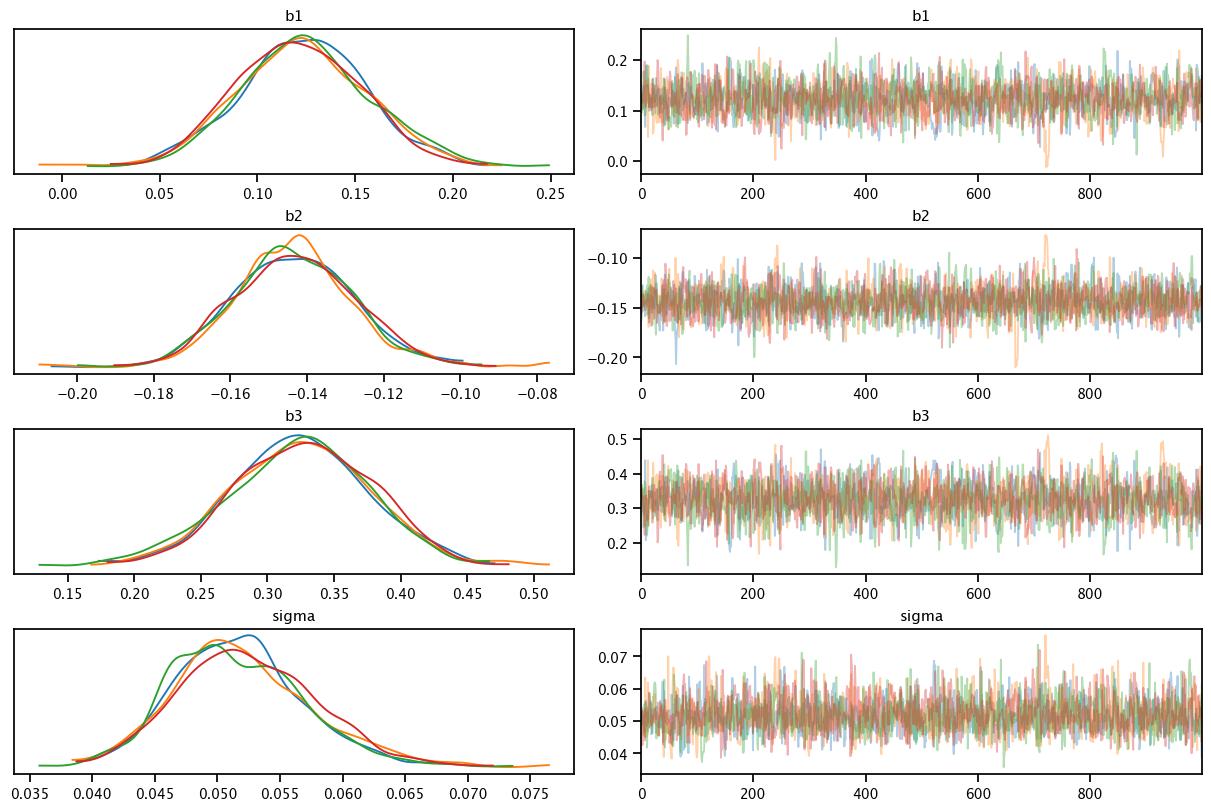

In [8]:
import arviz as az

print(fit.summary(percentiles=(10, 50, 90)))

inference_data_5_3 = az.from_cmdstanpy(fit, log_likelihood="lp__")

az.plot_trace(
    inference_data_5_3,
    var_names=["b1", "b2", "b3", "sigma"],
    compact=False,
    backend_kwargs={"constrained_layout": True},
)

- 回帰係数の解釈
    この結果を解釈するにあたって、相関関係と因果関係の違いに注意する必要がある。つまり回帰分析の結果、このモデルは
    $$
    \begin{align}
    &\mu[n] = 0.32 + 0.14A[n] + 0.32Score[n] &n=1, ..., N \nonumber \\
    &Y[n] \sim Normal(\mu[n], 0.05)          &n=1, ..., N \nonumber
    \end{align}
    $$
    このように書けるが、これは「A(アルバイトの好き嫌い)が変わらない場合は、Scoreが100点増えると出席率が平均的に0.16増えている」という手元のデータの関係性を述べており、因果化関係はわからない。

    実際にScoreを100点増やすという操作をした場合にどれほど出席率が増えるか予測するには、モデル式が因果関係を表している必要がある。今回は、説明変数(A, Score)が応答変数(Y)より時間的に先行していることと経験則から、モデル式が因果関係を反映ししているとする。
    
    - モデルが因果関係を反映していない例
        
        4.4節で年齢を説明変数、応答変数を年収と設定したが、これが逆(説明変数:年収、応答変数:年齢)だった場合は、年収を増やせば年齢が増えるという明らかに間違った解釈となる。

- 外挿  
    入力したデータの範囲(例えば今回はScore 51~185点)から外れた範囲(例えばScore0点)の予測をすることを外挿(extrapolation)というが、算出結果をそのまま信用して使うのは避けるべき(今回のモデルでは出席率がマイナスになりありえない)

- パラメータ幅の確認
    解釈において、大事なのは2.2節で述べたように分布と幅。
    例えばb3の95%ベイズ信頼区間は0.22~0.42であり、0から大きく離れているため、たしかにScoreが高ければ出席率は上がるだろう。
    しかしもしb3の95%ベイズ信頼区間が-0.4~0.8だったら、この区間は0を含んでいるのでScoreが高ければ出席率が上がるとは言えないだろう。

### 5.1.8 図によるモデルのチェック

データYとベイズ予測区間をA=0,1毎に分けて描画

/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


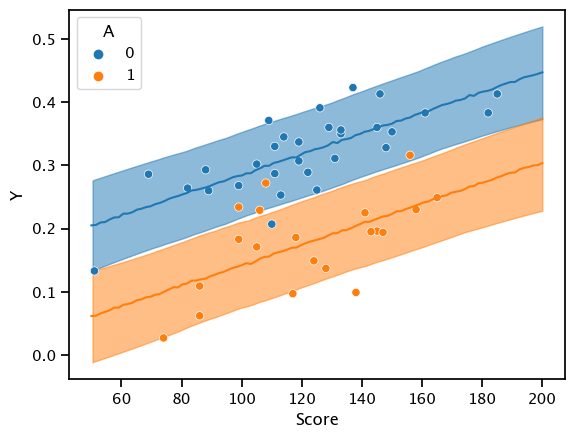

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from cmdstanpy import CmdStanMCMC
from numpy import ndarray
import arviz as az


def calc_y_pred(fit: CmdStanMCMC, Score_new: ndarray, A: int = 0):
    rg = np.random.default_rng(1234)
    # ブロードキャストするためにreshape(-1, 1)で2次元の縦行列に変換しつつ計算する
    y_pred = (
        fit.b1.reshape(-1, 1)
        + fit.b2.reshape(-1, 1) * A
        + fit.b3.reshape(-1, 1) * Score_new / 200
        + rg.normal(
            scale=fit.sigma.reshape(-1, 1), size=[fit.sigma.size, Score_new.size]
        )
    )
    return y_pred


prob = [10, 50, 90]
Score_new = np.linspace(50, 200, 100)
y_pred_list = [calc_y_pred(fit, Score_new, A=i) for i in d["A"].unique()]

ax = plt.axes()
colors = ["C0", "C1"]
for i in range(2):
    az.plot_hdi(
        Score_new,
        y_pred_list[i],
        plot_kwargs={"ls": "--"},
        hdi_prob=0.8,
        ax=ax,
        color=colors[i],
    )
    y_pred_median = np.percentile(y_pred_list[i], q=(50), axis=0).T
    ax.plot(Score_new, y_pred_median, color=colors[i], label="")

sns.scatterplot(d, x="Score", y="Y", hue="A", ax=ax)
plt.show()


筆者おすすめの可視化での確認方法

- 実測値と予測値のプロット
  
  横軸を実測値(手持ちの説明変数データ)、縦軸をその実測値から予測した予測値の信頼区間とする(中央値+バーで表現)。y=xの直線付近にあるかを見る。

- 推定されたノイズの分布
  
  $\varepsilon[n]$が、想定した分布$Normal(0, \sigma)$に一致するかを確認する。このモデルの場合$\varepsilon[n] = Y[n] - \mu[n]$で計算できる。$\mu[n]$は学生ごとに分布として得られるので$\varepsilon[n]$も分布として得られる。分布を人数分プロットすると見づらいため、$\varepsilon[n]$の分布の代表値(事後平均、中央値、MAP推定値など)を選び、その代表値の分布をヒストグラムなどで確認する。

  この方法はパラメータが特定の確率分布に従うと仮定した場合に、推定された値がその分布に従っているかどうかを確認するのにも応用できる。

これらを確認して問題がある場合はモデルの当てはまりが良くないと考えられるので、モデルを改善する。もしくは説明変数が不足している可能性がある。

また、使用したモデルについての理解を深めるために「MCMCサンプルの散布図行列(pairplot)」を見るのも大事。

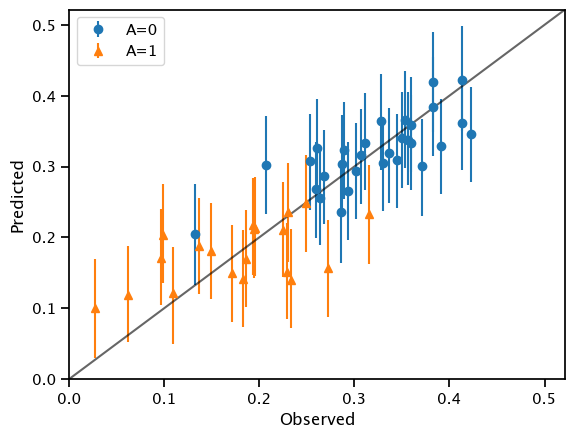

In [10]:
#  実測値と予測値のプロット

import numpy as np
import polars as pl


def calc_quantiles(y_pred: np.ndarray, prob: list[int]) -> pl.DataFrame:
    d_est = pl.DataFrame(
        np.percentile(y_pred, prob, axis=0).T, schema=[f"p{p}" for p in prob]
    )
    return d_est


prob = [10, 50, 90]

d_est_list = [
    calc_quantiles(fit.y_pred[:, d["A"] == i], prob=prob) for i in d["A"].unique()
]

ax = plt.axes()
FMT = ["o", "^"]
for i in d["A"].unique():
    d_part = d_est_list[i]
    err_lower = d_part["p50"] - d_part["p10"]
    err_upper = d_part["p90"] - d_part["p50"]
    ax.errorbar(
        d.filter(pl.col("A") == i)["Y"],
        "p50",
        data=d_part,
        yerr=[err_lower, err_upper],
        fmt=FMT[i],
        label=f"A={i}",
    )
# ax.axline(1, 1)
_, xmax = ax.get_xlim()
_, ymax = ax.get_ylim()
lim = (0, max(xmax, ymax))
ax.plot(lim, lim, c="k", alpha=3 / 5)
ax.legend()
plt.setp(ax, xlim=lim, ylim=lim, xlabel="Observed", ylabel="Predicted")
plt.show()

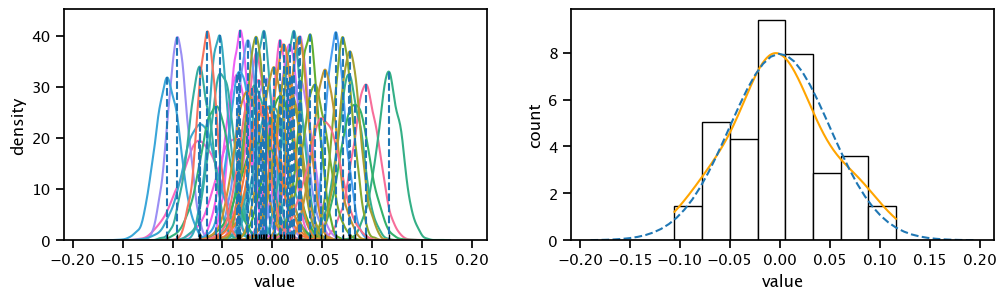

In [11]:
# 推定されたノイズの分布
import polars as pl
from scipy import stats
import seaborn as sns

N_mcmc = fit.num_draws_sampling * fit.chains

d_noise = pl.DataFrame(
    d["Y"].to_numpy() - fit.mu,
    schema=[f"noise{i}" for i in range(d.shape[0])],
)


def get_map(col):
    kernel = stats.gaussian_kde(col)
    dens_x = np.linspace(min(col), max(col), kernel.n)
    dens_y = kernel.pdf(dens_x)
    mode_x = dens_x[np.argmax(dens_y)]
    mode_y = dens_y[np.argmax(dens_y)]
    return (mode_x, mode_y)


d_mode = d_noise.transpose().apply(get_map)
d_mode.columns = ["X", "Y"]

# 左図
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3), sharex=True)
# d_noise.to_pandas().plot.kde(ax=ax1, legend=False)
sns.kdeplot(d_noise, ax=ax1, legend=False, common_norm=False)
ax1.vlines(d_mode["X"], d_mode["Y"], 0, linestyles="dashed")
sns.rugplot(d_mode["X"], ax=ax1, color="k")
plt.setp(ax1, xlabel="value", ylabel="density")

# 右図
s_MAP = pl.DataFrame([get_map(fit.sigma)], schema=["X", "Y"])
sns.histplot(
    d_mode["X"], ax=ax2, kde=True, stat="density", color="orange", facecolor="w"
)
xmin, xmax = ax2.get_xlim()
dens_x = np.linspace(xmin, xmax, 50)
ax2.plot(dens_x, stats.norm.pdf(dens_x, scale=s_MAP["X"]), linestyle="dashed")
plt.setp(ax2, xlabel="value", ylabel="count")

plt.show()

<Figure size 640x480 with 0 Axes>

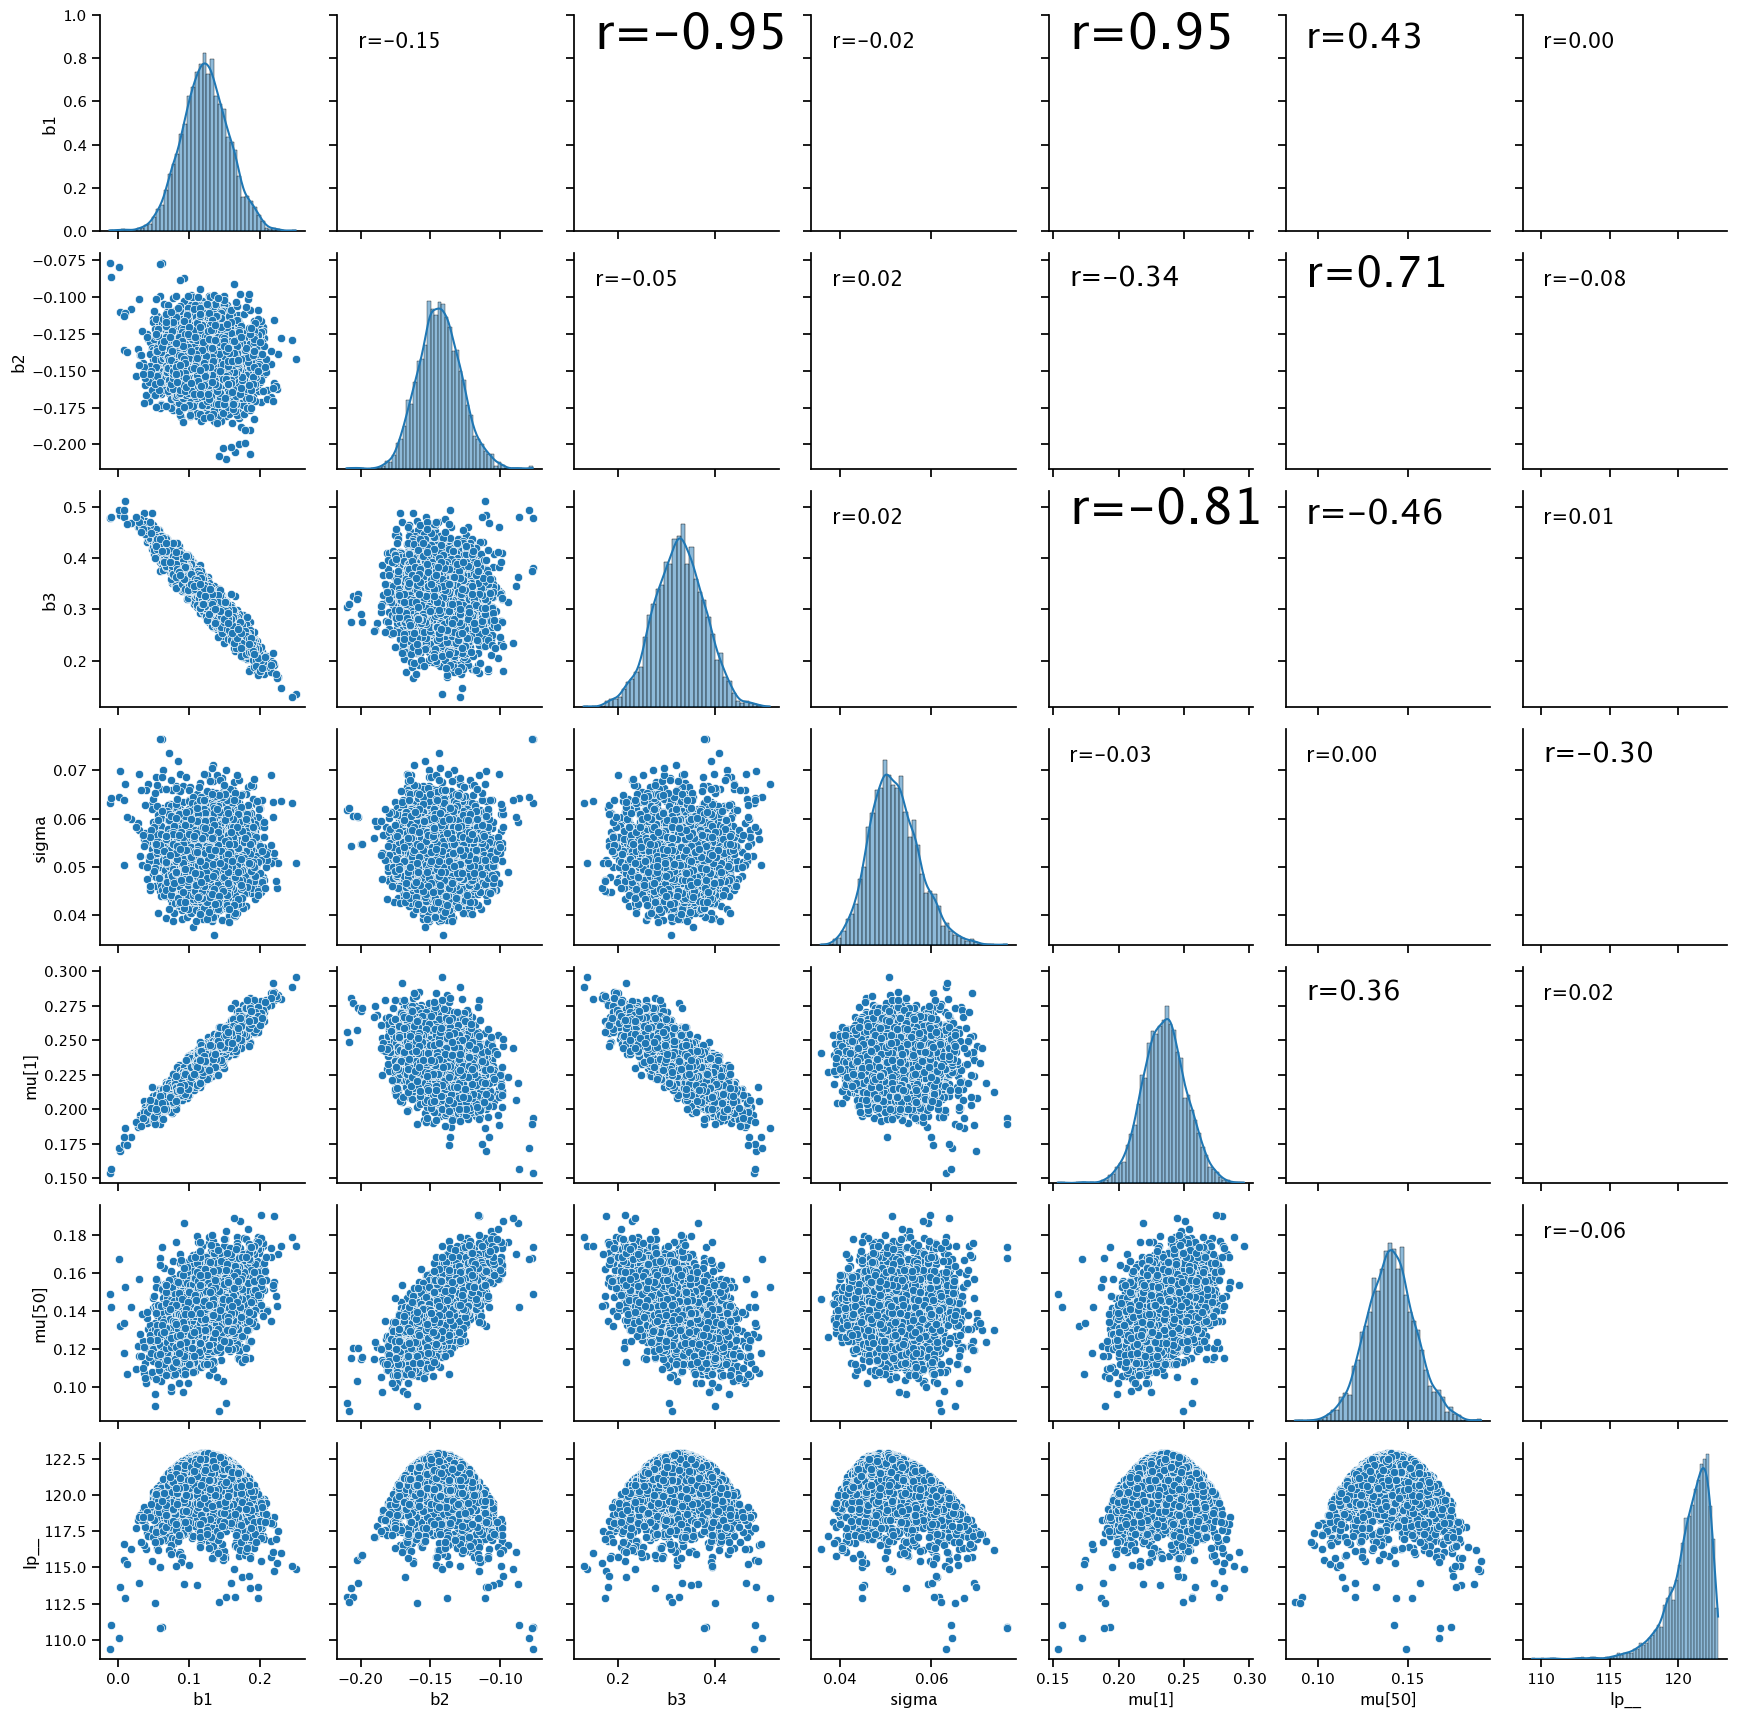

In [12]:
import polars as pl
from polars import selectors as cs
from seaborn_analyzer import CustomPairPlot

df = pl.DataFrame(fit.draws_pd()).select(~cs.starts_with("y_pred"))
cp = CustomPairPlot()
cp.pairanalyzer(
    df.to_pandas(),
    vars=["b1", "b2", "b3", "sigma", "mu[1]", "mu[50]", "lp__"],
    diag_kind="hist",
    diag_kws={"kde": True},
)

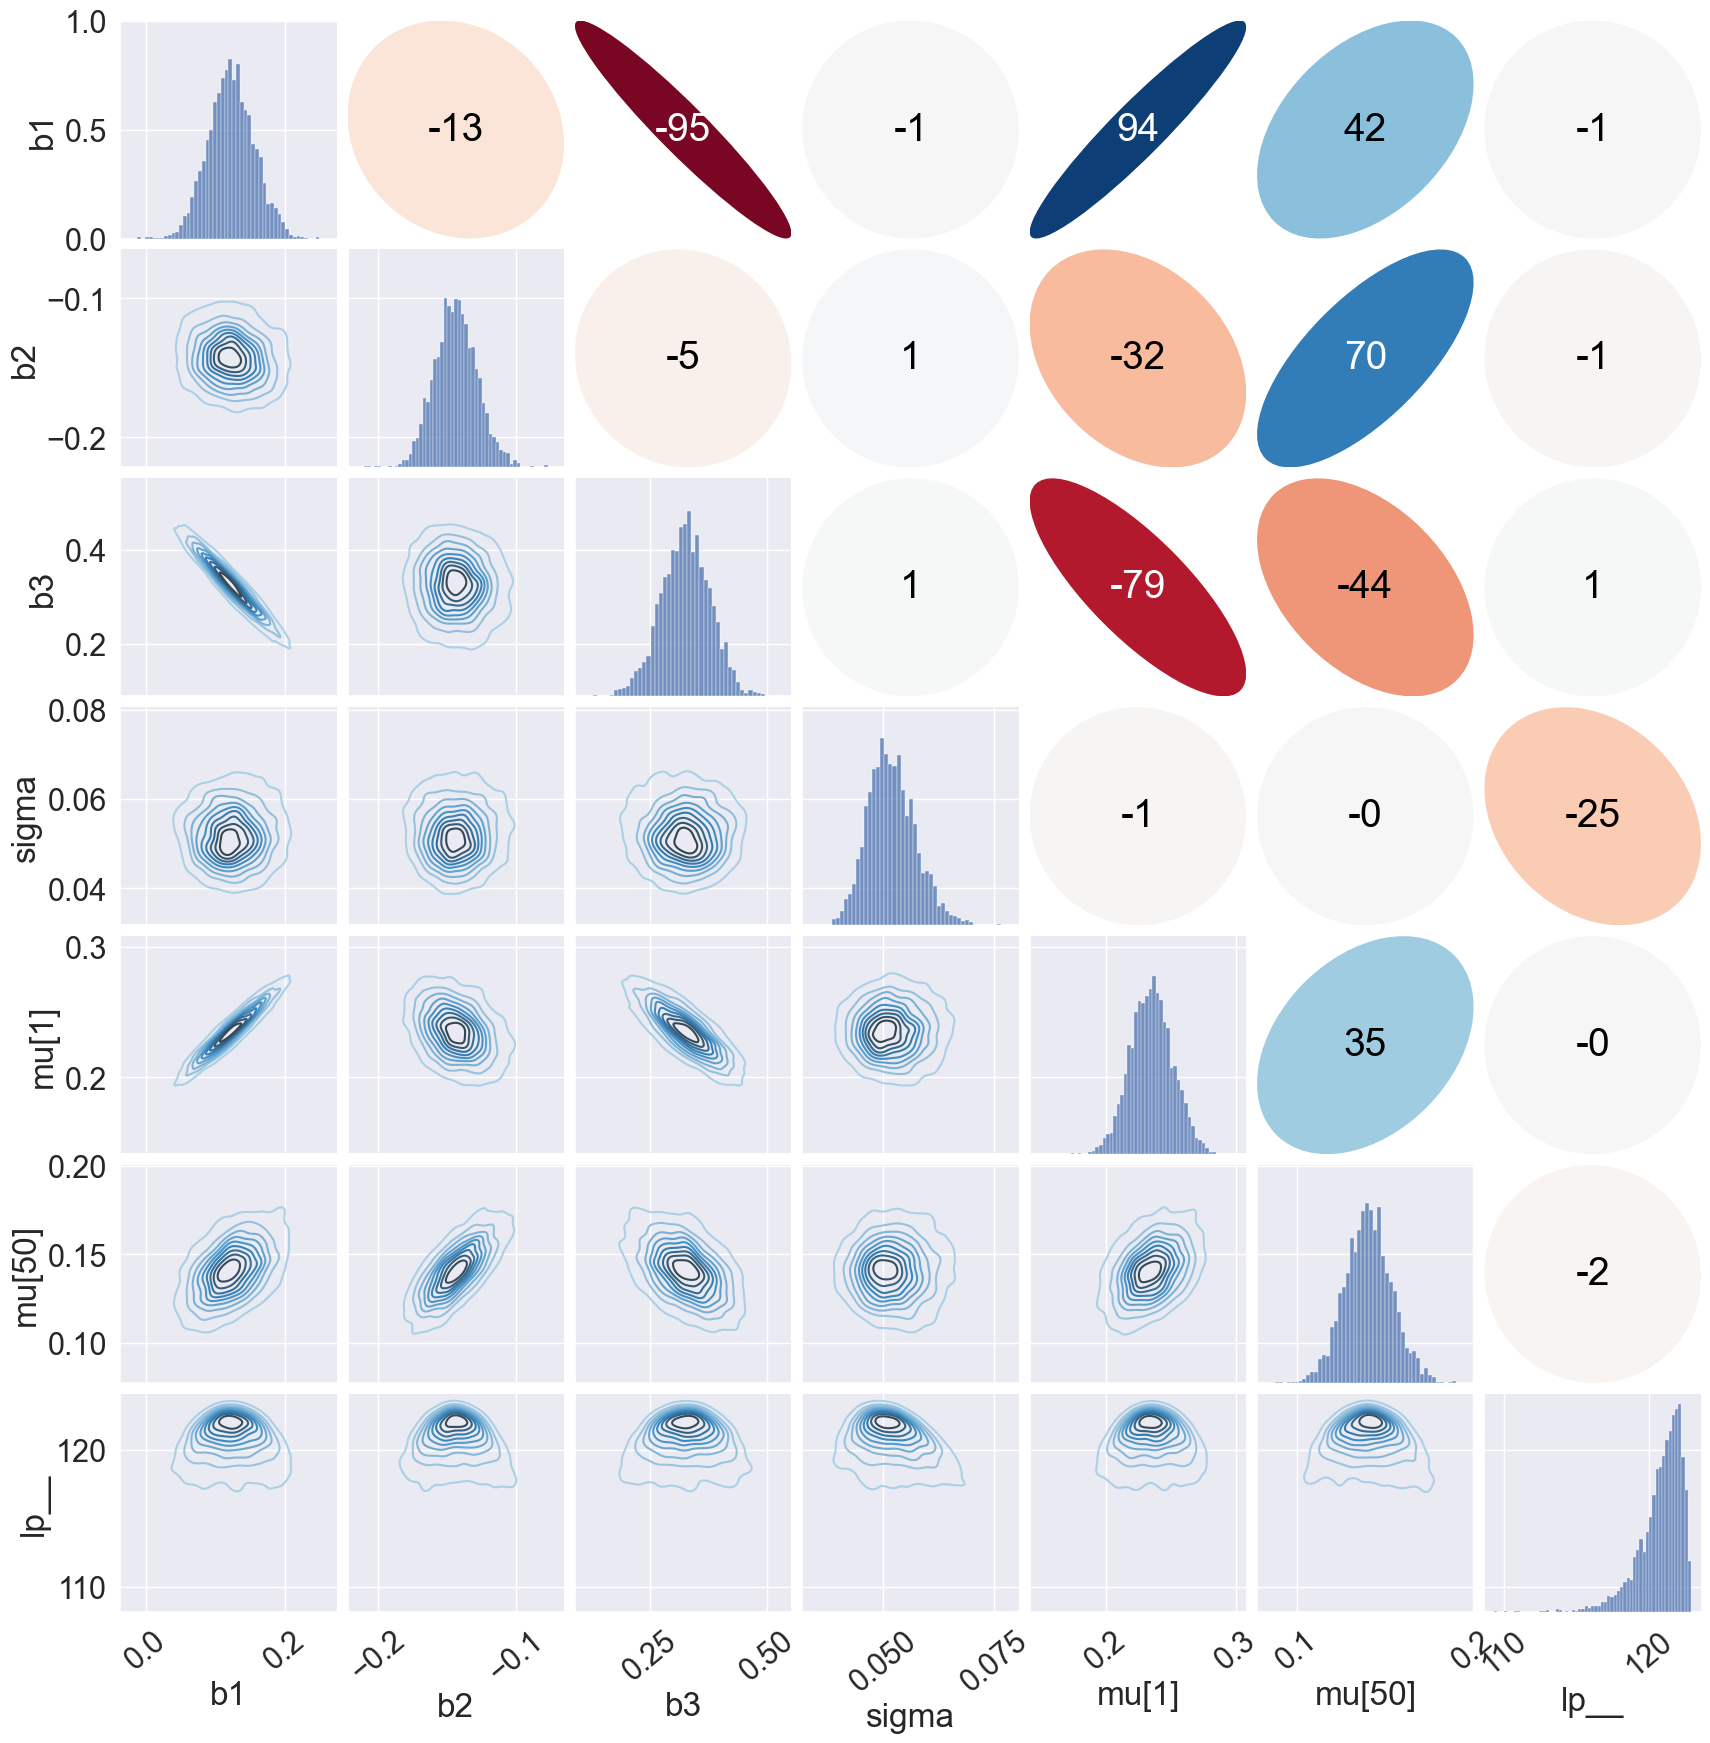

In [13]:
# 著者のコードでの可視化(https://statmodeling.hatenablog.com/entry/pystan-rstanbook-chap5-1)

import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.patches import Ellipse
from scipy import stats


def corrfunc(x, y, **kws):
    r, _ = stats.spearmanr(x, y)
    ax = plt.gca()
    ax.axis("off")
    ellcolor = plt.cm.RdBu(0.5 * (r + 1))
    txtcolor = "black" if math.fabs(r) < 0.5 else "white"
    ax.add_artist(
        Ellipse(
            xy=[0.5, 0.5],
            width=math.sqrt(1 + r),
            height=math.sqrt(1 - r),
            angle=45,
            facecolor=ellcolor,
            edgecolor="none",
            transform=ax.transAxes,
        )
    )
    ax.text(
        0.5,
        0.5,
        "{:.0f}".format(r * 100),
        color=txtcolor,
        fontsize=28,
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
    )


sns.set(font_scale=2)
g = sns.PairGrid(
    df.to_pandas(), vars=["b1", "b2", "b3", "sigma", "mu[1]", "mu[50]", "lp__"]
)
g = g.map_lower(sns.kdeplot, cmap="Blues_d")
g = g.map_diag(sns.histplot)
g = g.map_upper(corrfunc)
g.fig.subplots_adjust(wspace=0.05, hspace=0.05)
for ax in g.axes.flatten():
    for t in ax.get_xticklabels():
        _ = t.set(rotation=40)
plt.show()

## 5.2 二項ロジスティクス

### 5.2.2 データの分布の確認

データファイル

[chap05/input/data-attendance-2.txt](chap05/input/data-attendance-2.txt)

/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWa

<Figure size 640x480 with 0 Axes>

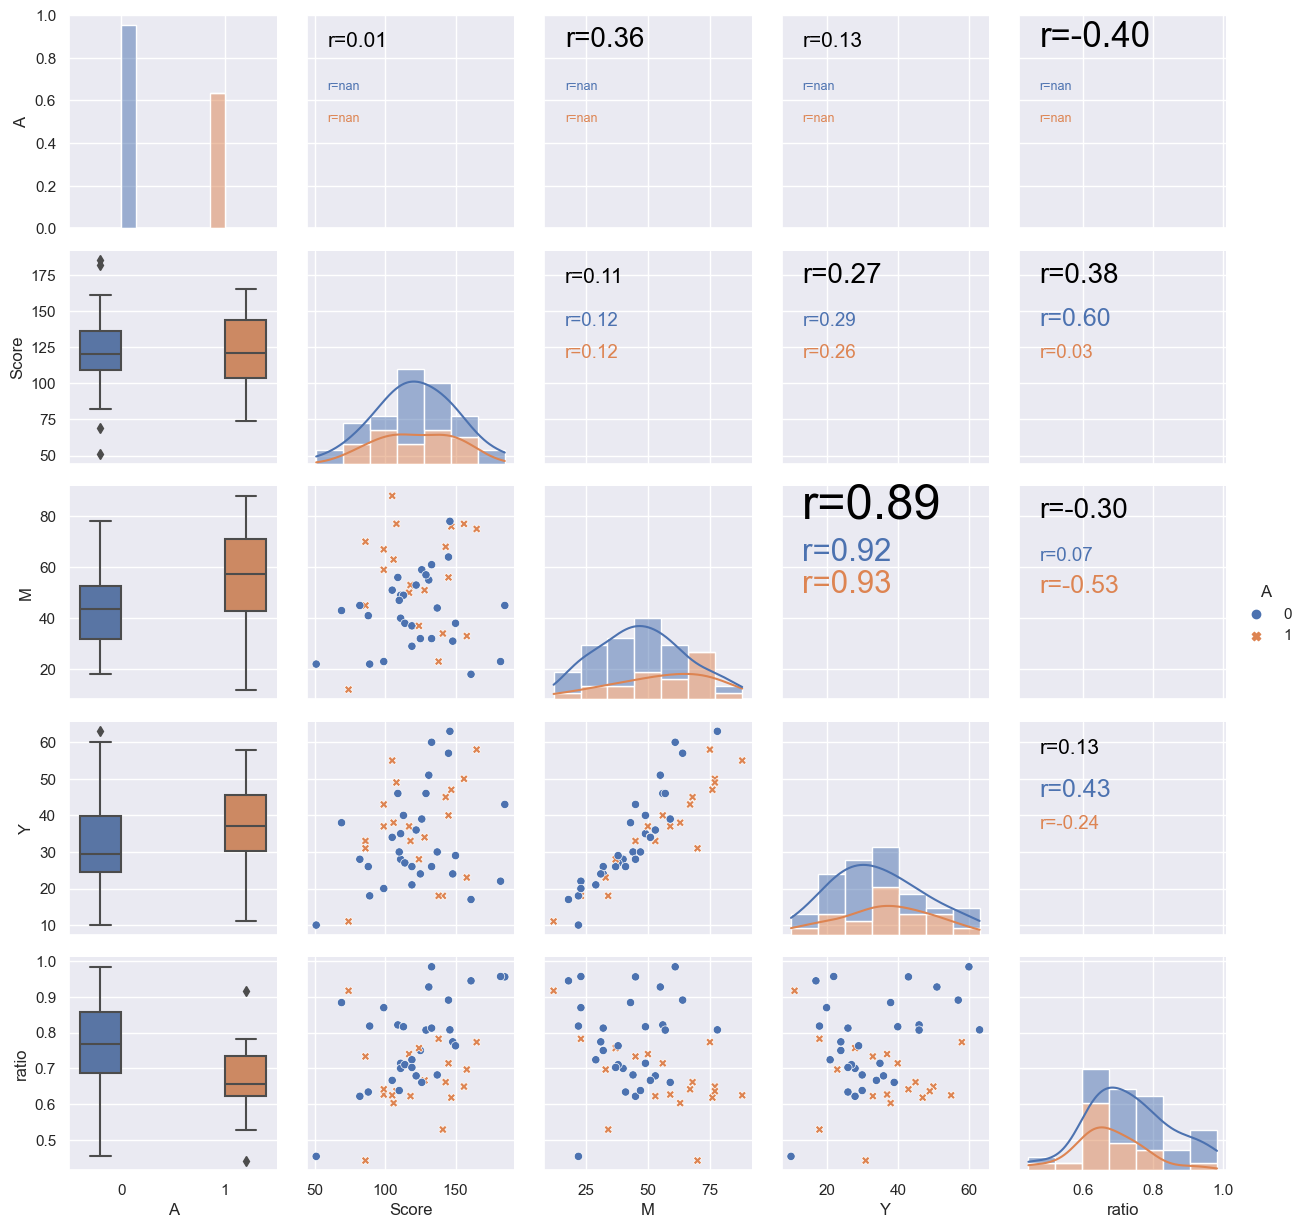

In [14]:
import polars as pl
from seaborn_analyzer import CustomPairPlot


df = pl.read_csv("chap05/input/data-attendance-2.txt")
df = df.with_columns((pl.col("Y") / pl.col("M")).alias("ratio"))

cpp = CustomPairPlot()
cpp.pairanalyzer(
    df.to_pandas(),
    vars=["A", "Score", "M", "Y", "ratio"],
    hue="A",
    diag_kind="hist",
    diag_kws={"kde": True, "multiple": "stack"},
)

### 5.2.3 メカニズムの想像

$ratio列=Y/M(出席率)$を応答変数に設定して重回帰分析する場合を考える。出席率の実測値がほぼ1であるデータがいくつかあるため、説明変数の組み合わせによっては出席率の予測値が1を超えてしまう。これでは現実に即していない。

そこで説明変数の線形結合の式$b_1+b_2A+b_3Score$が取りうる範囲($-\infty, \infty$)を(0, 1)の範囲に変換する。よく使われるのはinverse logit (logitの逆関数)、つまりロジスティック関数$1/{1+exp(-x)}$による変換である。

ロジスティック関数
![Alt text](chap05/output/fig5-7.png)

Stanではinv_logit関数が用意されている。なお、それぞれの説明変数の値が大きくなるに従ってYは単調に大きくなる(または単調に小さくなる)と仮定しているため、説明変数の線形結合を単調増加関数であるロジスティック関数で変換できる。

さて、変換後の値に正規分布に従うノイズが加わると、また[0, 1]範囲をはみ出る可能性が出てくる。さらに出席率の分母M(授業回数)を見ると12~88で比較的小さいため、出席率を連続値とみなすのは難しい。なので、正規分布を用いたモデルはよく当てはまっていないと考え、二項分布を用いる。

本来授業回数、出席回数のようなカウントデータに対しては二項分布モデルのほうが正確だが、[5.1節](#51-重回帰)では出席率が極端な値でなく、分母の授業回数が大きければ二項分布は正規分布に近似できるため正規分布を使っていた。(確率的プログラミング言語では、正規分布のほうが推定計算が高速)

近似していいか迷う場合は、正規分布モデルを先に使って問題がありそうでなら二項分布に変えるという選択肢もある。

まとめると、$b_1+b_2A+b_3Score$をロジスティック関数で(0, 1)の範囲に変換した出席確率qが決まり、Mとqの二項分布に従ってYが生成されるというモデルを考える。

### 5.2.4 モデル式の記述

- モデル式5-4
  $$
  \begin{align}
  &q[n] = inv_logit(b_1+b_2A+b_3Score) &n = 1, ..., N \nonumber \\
  &Y[n] \sim Binominal(M[n], q[n]) &n = 1, ..., N \nonumber
  \end{align}
  $$

### 5.2.5 Stanで実装

[chap05/model/model5-4.stan](chap05/model/model5-4.stan)

#### run-model5-4.RのPython版

データ

[chap05/input/data-attendance-2.txt](chap05/input/data-attendance-2.txt)

In [23]:
import polars as pl
from cmdstanpy import CmdStanModel

d = pl.read_csv("chap05/input/data-attendance-2.txt")

data = {
    "N": d.shape[0],
    "A": d["A"].to_list(),
    "Score": (d["Score"] / 200).to_list(),  # スケーリング
    "M": d["M"].to_list(),
    "Y": d["Y"].to_list(),
}

sm = CmdStanModel(
    stan_file="chap05/model/model5-4.stan", cpp_options={"STAN_THREADS": "TRUE"}
)
fit = sm.sample(data=data, seed=1234)

21:31:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:31:56 - cmdstanpy - INFO - CmdStan done processing.


### 5.2.6 推定結果の解釈

モデルの解釈にはinv_logitの理解が必要

In [24]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-1389.360000,0.032062,1.205200,-1391.790000,-1389.070000,-1388.030000,1413.00,2509.78,1.001340
b1,0.094516,0.006270,0.222922,-0.276061,0.095457,0.452845,1263.95,2245.02,1.002780
b2,-0.620266,0.002499,0.093764,-0.776578,-0.619055,-0.465782,1407.68,2500.32,1.002070
b3,1.897900,0.010024,0.360284,1.297310,1.896670,2.502420,1291.82,2294.54,1.002000
q[1],0.678544,0.000658,0.024232,0.637005,0.679190,0.717099,1354.64,2406.11,1.002950
...,...,...,...,...,...,...,...,...,...
y_pred[46],38.189500,0.052658,3.174290,33.000000,38.000000,43.000000,3633.88,6454.49,0.999924
y_pred[47],14.050700,0.041011,2.385080,10.000000,14.000000,18.000000,3382.20,6007.46,1.001260
y_pred[48],31.149700,0.041108,2.423490,27.000000,31.000000,35.000000,3475.64,6173.43,1.000570
y_pred[49],16.971500,0.036343,2.179650,13.000000,17.000000,20.000000,3596.95,6388.89,1.001040


### 5.2.7 図によるモデルのチェック

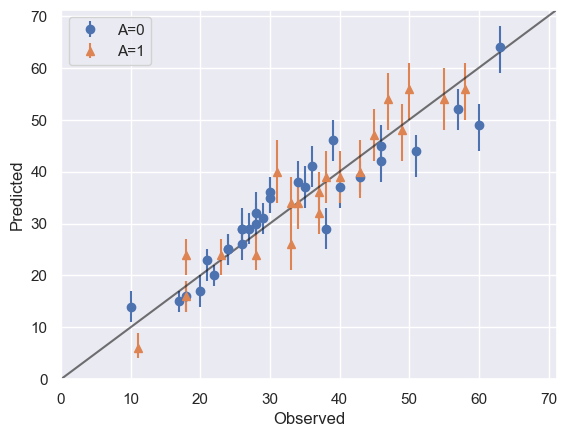

In [25]:
import numpy as np
import polars as pl
from polars import DataFrame


def calc_quantiles(y_pred: ndarray, prob: list[int]) -> DataFrame:
    d_est = pl.DataFrame(
        np.percentile(y_pred, prob, axis=0).T, schema=[f"p{p}" for p in prob]
    )
    return d_est


prob = [10, 50, 90]

d_est_list = [
    calc_quantiles(fit.y_pred[:, d["A"] == i], prob=prob) for i in d["A"].unique()
]

ax = plt.axes()
FMT = ["o", "^"]
for i in d["A"].unique():
    d_part = d_est_list[i]
    err_lower = d_part["p50"] - d_part["p10"]
    err_upper = d_part["p90"] - d_part["p50"]
    ax.errorbar(
        d.filter(pl.col("A") == i)["Y"],
        "p50",
        data=d_part,
        yerr=[err_lower, err_upper],
        fmt=FMT[i],
        label=f"A={i}",
    )
# ax.axline(1, 1)
_, xmax = ax.get_xlim()
_, ymax = ax.get_ylim()
lim = (0, max(xmax, ymax))
ax.plot(lim, lim, c="k", alpha=3 / 5)
ax.legend()
plt.setp(ax, xlim=lim, ylim=lim, xlabel="Observed", ylabel="Predicted")
plt.show()

## 5.3 ロジスティック回帰

出席率の予測に天気(晴、曇、雨)が関係しているとしてロジスティック回帰を行う。

データ

[chap05/input/data-attendance-3.txt](chap05/input/data-attendance-3.txt)

ではweather列は[A,B,C] (A:晴、B:曇、C:雨)が対応する。

### 5.3.1 解析の目的

3つ(A, Score, Weather)の説明変数で、応答変数Yがどれだけ予測できるか。また、それぞれの説明変数が出席率にどれだけ影響しているか知りたい。

### 5.3.2 データの分布の確認

説明変数が2値やカテゴリー値のため、散布図行列は使えない。天気(A，B，C)を行。データY(0, 1)を列にして集計してみる。


In [26]:
import polars as pl

d = pl.read_csv("chap05/input/data-attendance-3.txt")
d.pivot("Y", "Weather", "Y", aggregate_function="count").sort("Weather").select(
    "Weather",
    "0",
    "1",
)

Weather,0,1
str,u32,u32
"""A""",306,953
"""B""",230,500
"""C""",138,269


### 5.3.3 背景知識を使った値の変換

天気(A, B, C)は文字列で扱いづらいので(0, 0.2, 1)と置き換える(経験則から曇と雨で5倍影響が違うとする)。このように、背景知識を家庭としてモデルに組み込むのは重要。

### 5.3.4 メカニズムの想像

[5.2節](#523-メカニズムの想像)と同様に行う。ロジスティック関数で出席確率qに変換したあとは、二項分布でなくベルヌーイ分布に従ってYが決まるところが異なる。

### 5.3.5 モデル式の記述

モデル式5-5 
$$
\begin{align}
&q[i] = inv_logit(b_1+b_2A[i]+b_3Score[i]+b_4Weather[i]) &i = 1, ..., I \nonumber \\
&Y[i] \sim Bernoulli(q[i]) &i = 1, ..., I \nonumber
\end{align}
$$

添字をiにしたのはnが学生毎に対応していたが、今回はiは１出欠毎に対応するため。

学生による出欠行動の差は考慮していないモデル。学生による違いが大きいと考える場合は、8章の階層モデルにつながる。

### 5.3.6 Stanで実装

[chap05/model/model5-5.stan](chap05/model/model5-5.stan)

[model5-4](chap05/model/model5-4)との主な違いは、
- 天気の数値データWを追加
- 回帰係数の数が増えたので配列にした
- 確率的な変動の部分を2項分布からベルヌーイ分布に変更

個々の学生の出席確率q[i]が不要で、回帰係数のみを求める場合はbernulli_logit関数を使用して以下とする。(計算が高速)

[hap05/model/model5-5b.stan](chap05/model/model5-5b.stan)

#### run-model5-5.Rのpython版

In [30]:
import polars as pl
from cmdstanpy import CmdStanModel

d = pl.read_csv("chap05/input/data-attendance-3.txt")
data = {
    "I": d.shape[0],
    "A": d["A"].to_list(),
    "Score": (d["Score"] / 200).to_list(),  # スケーリング
    "W": d["Weather"].map_dict({"A": 0, "B": 0.2, "C": 1}).to_list(),
    "Y": d["Y"].to_list(),
}

sm = CmdStanModel(
    stan_file="chap05/model/model5-5.stan", cpp_options={"STAN_THREADS": "TRUE"}
)
fit = sm.sample(data=data, seed=1234)

21:36:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▏      | 00:03 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:03 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:04 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████     | 00:04 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:05 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 00:05 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:06 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |██


21:36:14 - cmdstanpy - INFO - CmdStan done processing.


### 5.3.7 図によるモデルのチェック

まずはY(散布図)と、qの信頼区間(80%)を重ねて描画する。A=0, Weather=0の場合のみ実施。

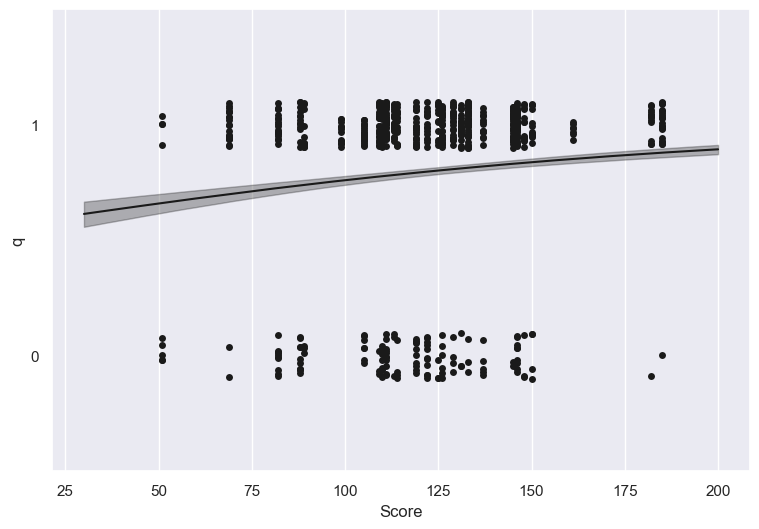

In [31]:
import numpy as np
from numpy import ndarray
from scipy.special import expit


def calc_q_mcmc(b_np: ndarray, A, weather):
    q_mcmc = (
        b_np[:, 0][:, np.newaxis]
        + b_np[:, 1][:, np.newaxis] * A
        + b_np[:, 2][:, np.newaxis] * X[np.newaxis, :] / 200
        + b_np[:, 3][:, np.newaxis] * weather
    )
    return q_mcmc


A = 0
WEATHER = 0
X = np.arange(30, 201)
b_np = fit.b
q_mcmc = calc_q_mcmc(fit.b, A, WEATHER)
d_est = pl.DataFrame(
    # scipy.special.expitでロジスティクス関数の解を計算
    expit(np.percentile(q_mcmc, (10, 50, 90), axis=0)).T,
    schema=("p10", "p50", "p90"),
)

plt.figure(figsize=(9, 6))
ax = plt.axes()
ax.plot(X, d_est["p50"], c="k")
ax.fill_between(X, d_est["p10"], d_est["p90"], color="k", alpha=0.3)
sns.stripplot(
    d.filter((pl.col("A") == 0) & (pl.col("Weather") == "A")).to_pandas(),
    x="Score",
    y="Y",
    jitter=True,
    orient="h",
    color="k",
    ax=ax,
)
plt.setp(ax, xlabel="Score", ylabel="q", ylim=ax.get_ylim()[::-1])
plt.show()

#### 他に使われることの多い可視化

- 確率と実測値のプロット
  
  出席確率の高さが実際の出席につながっているかを確認する。
  例えば、横軸にq[i]の事後分布の中央値、縦軸にY[i]をとる散布図を描く。
  点の数が多い場合には、q[i]の中央値の分布を表す密度関数や箱ひげ図もあわせて表示するとよい。
  今回のケースでは出席有無Yと出席率qの相関が見られないため、うまく予測できていないと解釈できる。

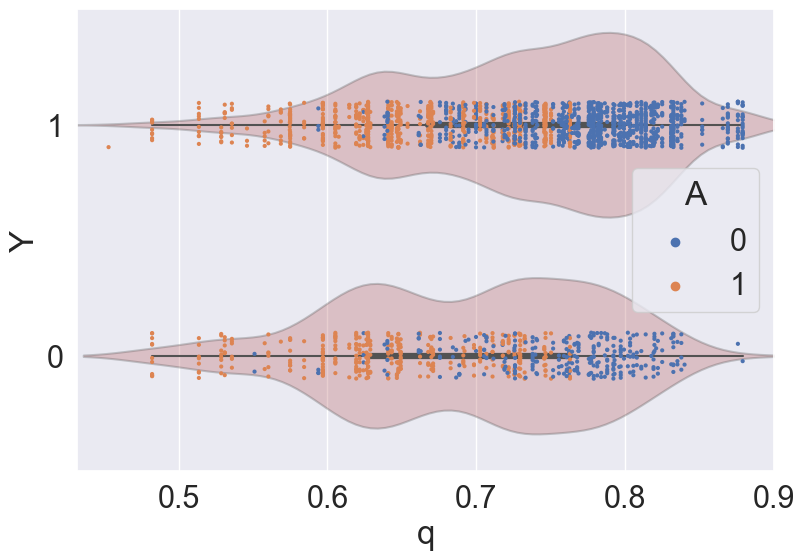

In [285]:
import polars as pl
import numpy as np

d_qua = pl.DataFrame(
    np.percentile(fit.q, (10, 50, 90), axis=0).T, ("p10", "p50", "p90")
)
d_qua = pl.concat([d, d_qua], how="horizontal")
plt.figure(figsize=(9, 6))
ax = plt.axes()
sns.violinplot(
    [d_qua.filter(pl.col("Y") == i)["p50"] for i in d["Y"].unique()],
    positions=[0, 1],
    orient="h",
    color="r",
)
plt.setp(ax.collections, alpha=0.3)
sns.stripplot(
    d_qua,
    x="p50",
    y="Y",
    hue="A",
    jitter=True,
    orient="h",
    size=3,
    ax=ax,
)
plt.setp(ax, xlabel="q", ylabel="Y", yticks=(0, 1), ylim=ax.get_ylim()[::-1])
plt.show()

- ROC曲線
  
  推定された出席確率に対して、判断の基準となる閾値をまず決める。(仮に0.6とする)
  閾値未満を欠席、以上を出席に置き換えて，実際の結果と見比べる。
  閾値を変化させて分類性能の曲線を作成し評価する。これがROC 曲線(ReceiverOperating Characteristic curve)である。
  曲線の下の面積(Area Under the Curve, AUCと呼ぶ)が1.0に近いほど分類性能がよい。一般によいとされる目安は0.8以上。
  今回は0.6169(80%ベイズ信頼区間は0.6155～0.6179)だったので，分類性能はあまりよくない。

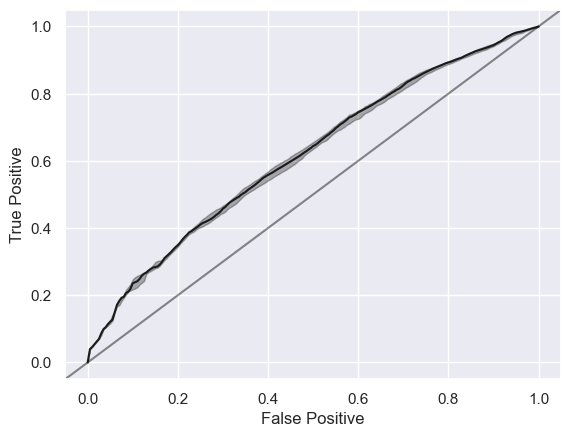

In [38]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import arviz as az

N_mcmc = fit.num_draws_sampling * fit.chains
N_spec = np.linspace(0, 1, 201)
probs = [10, 50, 90]


def roc(i):
    fpr, tpr, _ = roc_curve(d["Y"], fit.q[i, :], drop_intermediate=False)
    return np.interp(N_spec, fpr, tpr)


m_roc = np.array(list(map(roc, range(N_mcmc))))
d_est = pl.DataFrame(
    np.hstack((N_spec.reshape(-1, 1), np.percentile(m_roc, probs, axis=0).T)),
    ["X"] + ["p{}".format(p) for p in probs],
)

ax = plt.axes()
ax.plot(N_spec, d_est["p50"], c="k")
ax.fill_between("X", "p10", "p90", data=d_est, color="k", alpha=2 / 6)
# az.plot_hdi(N_spec, m_roc, ax=ax, hdi_prob=0.8, smooth=False)
lim = ax.get_xlim()
ax.plot(lim, lim, c="k", alpha=0.5)
plt.setp(ax, xlim=lim, ylim=lim, xlabel="False Positive", ylabel="True Positive")
plt.show()

## 5.4 ポアソン回帰

[5.2節](#52-二項ロジスティクス)と同じデータを用いるが、応答変数を出席回数Yでから総授業回数Mに変更する。授業回数のような離散的で非負の値を取るカウントデータに関してはポアソン分布を用いた回帰が第一選択肢となる。

### 5.4.1 メカニズムの想像

[5.1節](#513-メカニズムの想像)と同じく正規分布を使った重回帰をすると、授業回数の予測値が少数や負の値になる可能性があり良くない。ここで以下の2点を考える
- AとScoreの二つの説明変数の線形結合($b_1 + b_2A + b_3Score$)を0以上の範囲に変換して、平均授業回数$\lambda$が決まるとする
  - 0以上の範囲へ変換するために、使われることの多い方法は指数関数expを使う方法

- $\lambda$をパラメータとするポアソン分布に従って、Mが生成されたとする
    - ポアソン分布を使った回帰をポアソン回帰(Poisson regression)と呼ぶ

なお、説明変数の線形結合を単調増加関数である指数関数で変換しているので、それぞれの説明変数の値が大きくなるに従って、Yは単調に大きくなる(または単調に小さくなる)という仮定が背後にある。

また、パラメータ$\lambda$が十分大きい場合、ポアソン分布は正規分布で十分よく近似できるので正規分布を使ってもよい。

### 5.4.2 モデル式の記述

モデル式 5-6
$$
\begin{align}
&\lambda[n] = exp(b_1+b_2A[n]+b_3Score[n]) &n = 1, ..., N \nonumber \\
&M[n] \sim Poisson(\lambda[n]) &n = 1, ..., N \nonumber
\end{align}
$$

N:学生の人数, n:学生のインデックス

### 5.4.3 Stanで実装

[chap05/model/model5-6.stan](chap05/model/model5-6.stan)

[chap05/model/model5-4.stan](chap05/model/model5-4.stan)からの変更点
- 応答変数をMに変更
- exp関数を用いて$\lambda$が0以上になるよう変換
- 確率的な変動の部分の正規分布からポアソン分布に変更

poisson(x)を使うより、poisson_log(x) (poisson(exp(x))と等価)の使用が推奨されている。expを経由しない分計算が安定するようだ。

poisson_log関数を用いたバージョン
[chap05/model/model5-6b.stan](chap05/model/model5-6b.stan)

以下のpythonコードで実行する
#### run-model5-6.Rのpython版

In [39]:
import polars as pl
from cmdstanpy import CmdStanModel

d = pl.read_csv("chap05/input/data-attendance-2.txt")

data = {
    "N": d.shape[0],
    "A": d["A"].to_list(),
    "Score": (d["Score"] / 200).to_list(),  # スケーリング
    "M": d["M"].to_list(),
}

sm = CmdStanModel(
    stan_file="chap05/model/model5-6b.stan", cpp_options={"STAN_THREADS": "TRUE"}
)
fit = sm.sample(data=data, seed=1234)

08:27:42 - cmdstanpy - INFO - compiling stan file /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap05/model/model5-6b.stan to exe file /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap05/model/model5-6b
08:27:50 - cmdstanpy - INFO - compiled model executable: /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap05/model/model5-6b
08:27:50 - cmdstanpy - WARNING - Stan compiler has produced 6 warnings:
08:27:50 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap05/model/model5-6b.hpp /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap05/model/model5-6b.stan
Warning in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap05/model/model5-6b.stan', line 3, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the


08:27:51 - cmdstanpy - INFO - CmdStan done processing.


### 5.4.4 推定結果の解釈

パラメータの要約を以下のpythonコードで示す。得られた事後平均の値をモデル式に当てはめると以下になる。
$$
\begin{align}
&\lambda[n] = exp(3.58+0.26[n]+0.29Score[n]) &n = 1, ..., N \nonumber \\
&M[n] \sim Poisson(\lambda[n]) &n = 1, ..., N \nonumber
\end{align}
$$

expを用いているため、2つのパラメータ間で結果が何倍になるかという解釈がしやすい。以下に計算例を示す。

- Scoreが150点の学生と50点の学生の比較
  
  $$
  \begin{align}
  \frac{Score150点の時の授業回数の平均}{Score50点の時の授業回数の平均}
  &= \frac{exp(3.58) exp(0.26A) exp\left(0.29 \frac{150}{200}\right)}
  {exp(3.58)exp(0.26A) exp\left(0.29 \frac{50}{200}\right)} \nonumber \\
  &= exp\left(0.29\frac{150-50}{200}\right)
  \fallingdotseq 1.16 \nonumber 
  \end{align}
  $$

In [42]:
fit.summary(sig_figs=3)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,6900.000,0.033900,1.2100,6890.0000,6900.000,6900.000,1270.0,1500.0,1.0
b[1],3.580,0.002750,0.0957,3.4200,3.580,3.730,1215.0,1432.0,1.0
b[2],0.264,0.000971,0.0406,0.1980,0.263,0.329,1752.0,2066.0,1.0
b[3],0.286,0.004320,0.1500,0.0408,0.283,0.536,1200.0,1415.0,1.0
lambda[1],3.680,0.001320,0.0486,3.6000,3.680,3.760,1360.0,1603.0,1.0
...,...,...,...,...,...,...,...,...,...
m_pred[46],41.700,0.110000,6.6300,31.0000,41.000,53.000,3657.0,4313.0,1.0
m_pred[47],38.700,0.119000,6.7000,28.0000,38.000,50.000,3187.0,3759.0,1.0
m_pred[48],44.500,0.113000,6.8800,33.0000,44.000,56.000,3706.0,4371.0,1.0
m_pred[49],41.300,0.107000,6.5400,31.0000,41.000,52.000,3755.0,4428.0,1.0


#### 補足と文献案内

プロビット回帰: ロジスティック関数の代わりに標準正規分布の累積分布関数$\Phi$を使って(0, 1)の範囲に変換する。場合によってはロジスティック回帰よりも解釈しやすい。

#### 練習問題

(1) [chap05/model/model5-3.stan](chap05/model/model5-3.stan)を実行して得られるMCMCサンプルを使って、それぞれのnにおける$\varepsilon[n]=Y[n]-\mu[n]$のMCMC サンプルを算出するコードを書け。

In [3]:
import polars as pl
from cmdstanpy import CmdStanModel

d = pl.read_csv("chap05/input/data-attendance-1.txt")

data = {
    "N": d.shape[0],
    "A": d["A"].to_list(),
    "Score": (d["Score"] / 200).to_list(),  # スケーリング
    "Y": d["Y"].to_list(),
}

sm = CmdStanModel(
    stan_file="chap05/model/model5-3.stan", cpp_options={"STAN_THREADS": "TRUE"}
)
fit = sm.sample(data=data, seed=1234)

d_noise = pl.DataFrame(
    d["Y"].to_numpy() - fit.mu,
    schema=[f"noise{i}" for i in range(d.shape[0])],
)

d_noise.head()

21:53:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:53:35 - cmdstanpy - INFO - CmdStan done processing.


noise0,noise1,noise2,noise3,noise4,noise5,noise6,noise7,noise8,noise9,noise10,noise11,noise12,noise13,noise14,noise15,noise16,noise17,noise18,noise19,noise20,noise21,noise22,noise23,noise24,noise25,noise26,noise27,noise28,noise29,noise30,noise31,noise32,noise33,noise34,noise35,noise36,noise37,noise38,noise39,noise40,noise41,noise42,noise43,noise44,noise45,noise46,noise47,noise48,noise49
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.03628,-0.022458,-0.086162,-0.006795,-0.011079,-0.011083,0.007198,-0.027938,0.029297,-0.021963,0.013502,0.054957,0.014523,-0.035802,0.051678,0.044584,0.016978,-0.00834,-0.038565,0.078401,-0.053795,0.117924,0.078404,-0.019978,-0.072737,-0.051877,0.000278,-0.029722,-0.026804,-0.073282,-0.004259,-0.067914,-0.107278,-0.032917,0.042098,-0.046603,0.022144,-0.114062,-0.024521,0.01022,0.005877,-0.005083,-0.052942,-0.059184,-0.063345,-0.010361,-0.085399,-0.037664,-0.033921,0.095584
0.056424,-0.03603,-0.067863,-0.018424,-0.025079,0.006953,0.025959,-0.041576,0.046904,-0.004323,0.000062,0.072861,0.001841,-0.017041,0.070505,0.032528,0.03564,0.011375,-0.022243,0.064467,-0.065424,0.105571,0.066117,-0.033484,-0.085386,-0.064889,0.018775,-0.011225,-0.009691,-0.054587,-0.01849,-0.079148,-0.120619,-0.045797,0.060364,-0.028501,0.00989,-0.095268,-0.005036,0.029737,0.024045,0.012953,-0.034544,-0.041642,-0.046924,0.008596,-0.064662,-0.020188,-0.014766,0.083528
0.065605,-0.026434,-0.054417,-0.013321,-0.014492,0.021009,0.038339,-0.031827,0.06195,0.010647,0.009354,0.087221,0.009381,-0.004661,0.082732,0.03862,0.048248,0.021547,-0.004226,0.074901,-0.060321,0.112349,0.072743,-0.02404,-0.077923,-0.056588,0.031764,0.001764,0.006497,-0.042055,-0.00737,-0.074959,-0.111556,-0.0378,0.073886,-0.014598,0.016439,-0.082964,0.005669,0.040366,0.037796,0.027009,-0.021326,-0.026444,-0.029136,0.02052,-0.056852,-0.004837,-0.003299,0.08962
0.062233,-0.016983,-0.05516,-0.006641,-0.004431,0.020641,0.036938,-0.022283,0.062193,0.010843,0.018616,0.087042,0.017564,-0.006062,0.081238,0.045911,0.046989,0.018785,-0.002152,0.084868,-0.053641,0.120062,0.080362,-0.014683,-0.069787,-0.047935,0.030739,0.000739,0.007445,-0.043361,0.00302,-0.068842,-0.102434,-0.029336,0.07319,-0.015059,0.024012,-0.084412,0.003236,0.037886,0.037241,0.026641,-0.02221,-0.026107,-0.027202,0.018838,-0.061069,-0.004407,-0.005263,0.096911
0.035401,-0.019458,-0.076286,-0.015127,-0.005582,0.00033,0.014386,-0.024554,0.043206,-0.008246,0.015734,0.067138,0.012337,-0.028614,0.058482,0.038749,0.024742,-0.006722,-0.017165,0.083514,-0.062127,0.113817,0.073913,-0.017362,-0.075115,-0.052143,0.009002,-0.020998,-0.010013,-0.06571,0.002582,-0.078551,-0.105623,-0.033951,0.052166,-0.035574,0.017461,-0.107066,-0.021558,0.01299,0.016522,0.00633,-0.043642,-0.044889,-0.042521,-0.004326,-0.089735,-0.022985,-0.029038,0.089749


(2) [chap05/model/model5-3.stan](chap05/model/model5-3.stan)を修正し、Stan内でも$\varepsilon[n]$を算出するようにせよ。

[chap05/exercise/ex2.stan](chap05/exercise/ex2.stan)

```diff
  data {
    int N;
    int<lower=0, upper=1> A[N];
    real<lower=0, upper=1> Score[N];
    real<lower=0, upper=1> Y[N];
  }

  parameters {
    real b1;
    real b2;
    real b3;
    real<lower=0> sigma;
  }

  transformed parameters {
    real mu[N];
    for (n in 1:N)
      mu[n] = b1 + b2*A[n] + b3*Score[n];
  }

  model {
    for (n in 1:N)
      Y[n] ~ normal(mu[n], sigma);
  }

  generated quantities {
    real y_pred[N];
+   real noise[N];
    for (n in 1:N) {
      y_pred[n] = normal_rng(mu[n], sigma);
+     noise[n] = Y[n] - mu[n];
    }
  }
```

(3) [5.3.2項](#532-データの分布の確認)の続きで，アルバイトが好きかどうかごとにYを集計せよ。

In [5]:
import polars as pl

d = pl.read_csv("chap05/input/data-attendance-3.txt")
d.pivot("Y", "A", "Y", aggregate_function="count").sort("A").select(
    "A",
    "0",
    "1",
)

A,0,1
i64,u32,u32
0,288,994
1,386,728


(4) [5.3.3項](#533-背景知識を使った値の変換)では経験から曇りの影響と雨の影響の大きさの比を固定した。しかしながら、曇りと雨の影響の比について経験がない場合には、晴れの影響を0とし、曇りの影響と雨の影響をともにパラメータとするモデルも考えられる。Stanで実装して[chap05/exercise/ex4.stan](chap05/exercise/ex4.stan)推定せよ。(ヒント：天気のデータを1～3のインデックスにしてStanに渡す)

In [1]:
import polars as pl
from cmdstanpy import CmdStanModel


d = pl.read_csv("chap05/input/data-attendance-3.txt")

data = {
    "I": d.shape[0],
    "A": d["A"].to_list(),
    "Score": (d["Score"] / 200).to_list(),
    "WID": d["Weather"].map_dict({"A": 1, "B": 2, "C": 3}, default=0).to_list(),
    "Y": d["Y"].to_list(),
}

sm = CmdStanModel(
    stan_file="chap05/exercise/ex4.stan", cpp_options={"STAN_THREADS": "TRUE"}
)
fit = sm.sample(data=data, seed=1234)
fit.summary()

/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
22:43:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 00:02 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:03 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:04 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:05 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:06 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:07 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:08 Iteration:  800 / 2000 [ 40%]  (Warmup)


cha


22:44:01 - cmdstanpy - INFO - CmdStan done processing.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-1379.650000,0.035391,1.531830,-1382.510000,-1379.380000,-1377.730000,1873.38000,44.39300,0.999717
b[1],0.263238,0.004751,0.230074,-0.119703,0.266457,0.641825,2345.51000,55.58090,1.003570
b[2],-0.623349,0.001590,0.094129,-0.776262,-0.623010,-0.470378,3505.71000,83.07360,1.000720
b[3],1.967560,0.007348,0.365274,1.366460,1.964860,2.576070,2471.08000,58.55630,1.003400
bw2,-0.379120,0.001840,0.106790,-0.556720,-0.378220,-0.204580,3375.03336,79.97709,0.999790
bw3,-0.493440,0.002240,0.128180,-0.708960,-0.493830,-0.287440,3266.82746,77.41297,1.000250
bw[1],0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
bw[2],-0.379116,0.001838,0.106789,-0.556718,-0.378224,-0.204579,3375.03000,79.97710,0.999788
bw[3],-0.493442,0.002243,0.128184,-0.708962,-0.493828,-0.287440,3266.83000,77.41300,1.000250


(5) [chap05/model/model5-6b.stan](chap05/model/model5-6b.stan)の結果から、[5.4節](#54-ポアソン回帰)で省いた「実測値と予測値のプロット」を描け、5.1.8項で説明したような問題がないか確認せよ

22:57:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:57:33 - cmdstanpy - INFO - CmdStan done processing.


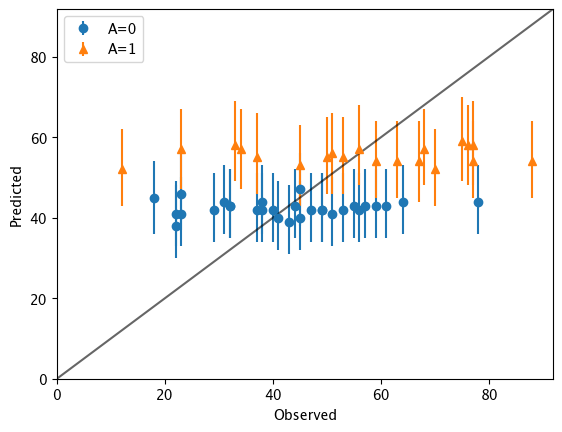

In [3]:
import numpy as np
from numpy import ndarray
import polars as pl
from polars import DataFrame
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt

d = pl.read_csv("chap05/input/data-attendance-2.txt")

data = {
    "N": d.shape[0],
    "A": d["A"].to_list(),
    "Score": (d["Score"] / 200).to_list(),  # スケーリング
    "M": d["M"].to_list(),
}

sm = CmdStanModel(
    stan_file="chap05/model/model5-6b.stan", cpp_options={"STAN_THREADS": "TRUE"}
)
fit = sm.sample(data=data, seed=1234)


#  実測値と予測値のプロット
def calc_quantiles(m_pred: ndarray, prob: list[int]) -> DataFrame:
    d_est = pl.DataFrame(
        np.percentile(m_pred, prob, axis=0).T, schema=[f"p{p}" for p in prob]
    )
    return d_est


prob = [10, 50, 90]

d_est_list = [
    calc_quantiles(fit.m_pred[:, d["A"] == i], prob=prob) for i in d["A"].unique()
]

ax = plt.axes()
FMT = ["o", "^"]
for i in d["A"].unique():
    d_part = d_est_list[i]
    err_lower = d_part["p50"] - d_part["p10"]
    err_upper = d_part["p90"] - d_part["p50"]
    ax.errorbar(
        d.filter(pl.col("A") == i)["M"],
        "p50",
        data=d_part,
        yerr=[err_lower, err_upper],
        fmt=FMT[i],
        label=f"A={i}",
    )
# ax.axline(1, 1)
_, xmax = ax.get_xlim()
_, ymax = ax.get_ylim()
lim = (0, max(xmax, ymax))
ax.plot(lim, lim, c="k", alpha=3 / 5)
ax.legend()
plt.setp(ax, xlim=lim, ylim=lim, xlabel="Observed", ylabel="Predicted")
plt.show()

(6) 本書のGitHubリポジトリ上の[chap05/input/data4a.csv](chap05/input/data4a.csv)のデータを使って、Stanでポアソン回帰を実行せよ．このデータファイルの構成は、調査した植物の個体ごとに行が分かれていて、y列が種子数(応答変数)、x列が体サイズ(説明変数その1)，t列が処理の違い(説明変数その2)である。

In [10]:
import polars as pl
from cmdstanpy import CmdStanModel

d = pl.read_csv("chap05/input/data3a.csv")

data = {
    "N": d.shape[0],
    "Y": d["y"].to_list(),
    "X": d["x"].to_list(),
    "F": d["f"].map_dict({"C": 0, "T": 1}).to_list(),
}

sm = CmdStanModel(
    stan_file="chap05/exercise/ex6.stan", cpp_options={"STAN_THREADS": "TRUE"}
)

fit = sm.sample(data, seed=1234)

fit.summary()

23:36:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |████████▏ | 00:01 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |█████████ | 00:01 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


23:36:04 - cmdstanpy - INFO - CmdStan done processing.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,829.211000,0.035564,1.261650,826.804000,829.538000,830.560000,1258.54,396.265,1.006920
b[1],1.273640,0.011475,0.377182,0.632389,1.276460,1.901350,1080.43,340.186,1.005510
b[2],0.078748,0.001148,0.037780,0.015664,0.078847,0.142299,1083.18,341.051,1.005590
b[3],-0.030399,0.001855,0.073886,-0.154977,-0.030335,0.090008,1586.54,499.540,1.005540
lambda[1],1.928030,0.002165,0.078651,1.795910,1.929560,2.058710,1319.19,415.363,1.004330
...,...,...,...,...,...,...,...,...,...
y_pred[96],7.124250,0.044728,2.740560,3.000000,7.000000,12.000000,3754.32,1182.090,0.999719
y_pred[97],6.835500,0.045299,2.678760,3.000000,7.000000,12.000000,3496.87,1101.030,0.999509
y_pred[98],7.796500,0.044143,2.802780,4.000000,8.000000,13.000000,4031.45,1269.350,0.999361
y_pred[99],8.130000,0.048456,2.900720,4.000000,8.000000,13.000000,3583.57,1128.330,1.001050



(7) 本書のGitHubリポジトリ上の[chap05/input/data4a.csv](chap05/input/data4a.csv)のデータを使って、Stanで二項ロジスティック回帰を実行せよ。その後「実測値と予測値のプロット」を描け。データファイルの構成は、N列が調査した種子数、y列がそのうち生存していた種子数(応答変数)、x列とf列は(6)と同じで説明変数である。

07:38:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████▍    | 00:01 Iteration: 1000 / 2000 [ 50%]  (Warmup)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |███████▎  | 00:01 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |████████▏ | 00:01 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |█████████ | 00:02 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed

chain 3 |██████████| 00:


07:38:53 - cmdstanpy - INFO - CmdStan done processing.


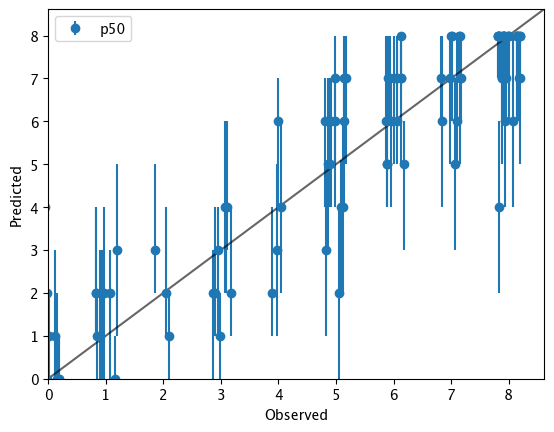

In [14]:
import polars as pl
from cmdstanpy import CmdStanModel

d = pl.read_csv("chap05/input/data4a.csv")

data = {
    "I": d.shape[0],
    "N": d["N"].to_list(),
    "Y": d["y"].to_list(),
    "X": d["x"].to_list(),
    "F": d["f"].map_dict({"C": 0, "T": 1}).to_list(),
}

sm = CmdStanModel(
    stan_file="chap05/exercise/ex7.stan", cpp_options={"STAN_THREADS": "TRUE"}
)
fit = sm.sample(data, seed=1234)


#  実測値と予測値のプロット
def calc_quantiles(y_pred: ndarray, prob: list[int]) -> DataFrame:
    d_est = pl.DataFrame(
        np.percentile(y_pred, prob, axis=0).T, schema=[f"p{p}" for p in prob]
    )
    return d_est


prob = [10, 50, 90]

d_est = calc_quantiles(fit.y_pred, prob=prob)

ax = plt.axes()
err_lower = d_est["p50"] - d_est["p10"]
err_upper = d_est["p90"] - d_est["p50"]

# d["y"]は離散値なので、プロット時に重ならないようずらす。
rg = np.random.default_rng(1234)
x = d["y"] + rg.uniform(-0.2, 0.2, d["y"].shape)
ax.errorbar(
    x,
    "p50",
    data=d_est,
    yerr=[err_lower, err_upper],
    fmt="o",
)
# ax.axline(1, 1)
_, xmax = ax.get_xlim()
_, ymax = ax.get_ylim()
lim = (0, max(xmax, ymax))
ax.plot(lim, lim, c="k", alpha=3 / 5)
ax.legend()
plt.setp(ax, xlim=lim, ylim=lim, xlabel="Observed", ylabel="Predicted")
plt.show()